# 08: Process Images

Scratch to figure out image processing method:

- Night light imagery:
    - Rioxarray --> PIL --> Resize and to tensor in Pytorch
- Get population count from census images
    - Rioxarray --> Sum to get total population in image --> Label (create csv with population and Image name)
        - Create classes based on population
        - Arrange images following the Pytorch `ImageFolder` organization so it can be read into Pytorch

In [137]:
import rioxarray
from PIL import Image
import numpy as np
import glob
import pandas as pd
from scripts.data_helpers_night_lights import convert_tiff_to_PIL

## Night Light Imagery

In [40]:
im = rioxarray.open_rasterio('../data/NightLightExport0905_0/lat_1.2671_lon_-78.9855_2000.tif')

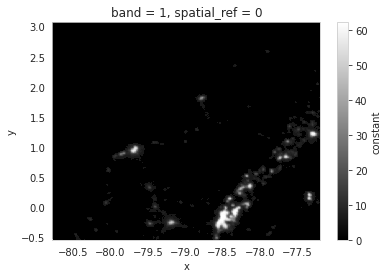

In [41]:
im.plot(cmap = 'gray')

In [6]:
im.shape

(1, 433, 431)

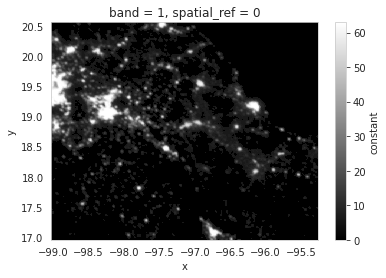

In [12]:
im2 = rioxarray.open_rasterio('../data/NightLightExport0905_0/lat_18.755_lon_-97.1522_2000.tif')
im2.plot(cmap = 'gray')

In [9]:
im2.shape

(1, 433, 454)

In [15]:
im2.sum()

<xarray.DataArray ()>
array(1022311.1674)
Coordinates:
    spatial_ref  int64 0

In [30]:
im2_array = im2.values.astype(np.uint8)

In [36]:
im2_array.squeeze().shape

(433, 454)

In [38]:
test_pil = Image.fromarray(im2_array.squeeze())
test_pil.show()

## Census Data

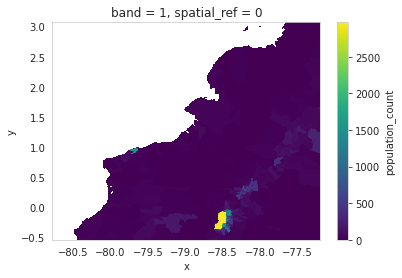

In [42]:
im_census = rioxarray.open_rasterio('../data/CensusExport0905_0/lat_1.2671_lon_-78.9855_2000.tif')
im_census.plot()

In [46]:
np.nansum(im_census.values.squeeze())

4644906.5

In [51]:
all_census = sorted(glob.glob('../data/CensusExport0905_0/*.tif'))

In [52]:
len(all_census)

597

In [56]:
# Get all populations
im_name = []
population = []

for file in all_census:

    im_name.append(file.split('/')[-1])

    image = rioxarray.open_rasterio(file)
    population.append(np.nansum(image.values.squeeze()))

In [58]:
population_df = pd.DataFrame({'file': im_name,
                              'population': population})

In [59]:
population_df.head()

,file,population
0,lat_-0.3329_lon_10.3832_2000.tif,1.211094e+06
1,lat_-0.3329_lon_10.3832_2005.tif,1.389461e+06
2,lat_-0.3329_lon_10.3832_2010.tif,1.597312e+06
3,lat_-0.4833_lon_15.9_2000.tif,6.377925e+05
4,lat_-0.4833_lon_15.9_2005.tif,7.030537e+05


<AxesSubplot:ylabel='Frequency'>

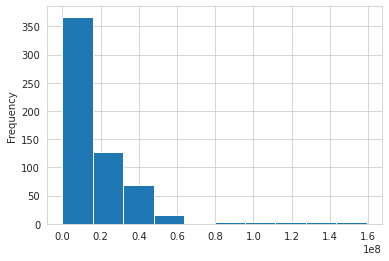

In [60]:
population_df['population'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

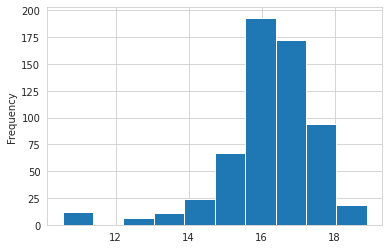

In [61]:
np.log(population_df['population']).plot.hist()

In [64]:
pop_quantiles = population_df.quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
pop_quantiles

,population
0.0,3.811604e+04
0.2,5.662274e+06
0.4,9.855760e+06
0.6,1.549055e+07
0.8,2.846734e+07
1.0,1.593108e+08


For now, let's try breaking this up into 5 quantiles and split each image.

In [121]:
class1 = population_df.loc[population_df['population'] <= pop_quantiles.population[0.2]].reset_index(drop=True)
class2 = population_df.loc[(population_df['population'] <= pop_quantiles.population[0.4]) &
                           (population_df['population'] > pop_quantiles.population[0.2])].reset_index(drop=True)
class3 = population_df.loc[(population_df['population'] <= pop_quantiles.population[0.6]) &
                           (population_df['population'] > pop_quantiles.population[0.4])].reset_index(drop=True)
class4 = population_df.loc[(population_df['population'] <= pop_quantiles.population[0.8]) &
                           (population_df['population'] > pop_quantiles.population[0.6])].reset_index(drop=True)
class5 = population_df.loc[(population_df['population'] <= pop_quantiles.population[1.0]) &
                           (population_df['population'] > pop_quantiles.population[0.8])].reset_index(drop=True)

In [122]:
#confirm number in each class
print(class1.shape)
print(class2.shape)
print(class3.shape)
print(class4.shape)
print(class5.shape)

(120, 2)
(119, 2)
(119, 2)
(119, 2)
(120, 2)


At this point, I realized I goofed up a bit on my initial sample... I needed to have also put a lower bound on population but I only put an upper bound for each bin! Hopefully the bin sizes are still okay...

In [75]:
pop_quantiles.diff()

,population
0.0,NaN
0.2,5.624158e+06
0.4,4.193486e+06
0.6,5.634794e+06
0.8,1.297678e+07
1.0,1.308434e+08


### Print out a sample image from each class

**Class1** - Up to 5.6 Million

In [85]:
class1_night = rioxarray.open_rasterio(f'../data/NightLightExport0905_0/{class1["file"][0]}')
class1_census = rioxarray.open_rasterio(f'../data/CensusExport0905_0/{class1["file"][0]}')

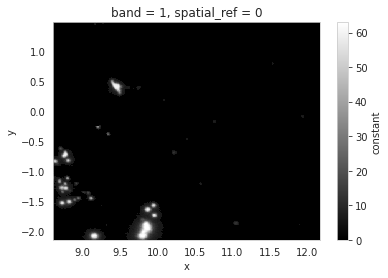

In [86]:
class1_night.plot(cmap = 'gray')

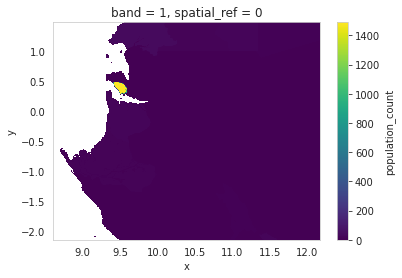

In [87]:
class1_census.plot()

In [88]:
class1["population"][0]

1211094.4

**Class 2** Up to 9.9 million

In [89]:
class2_night = rioxarray.open_rasterio(f'../data/NightLightExport0905_0/{class2["file"][0]}')
class2_census = rioxarray.open_rasterio(f'../data/CensusExport0905_0/{class2["file"][0]}')

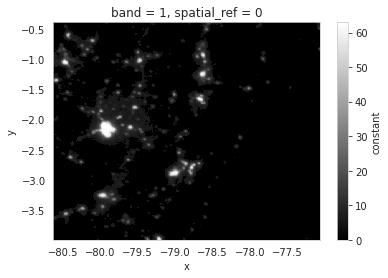

In [90]:
class2_night.plot(cmap = 'gray')

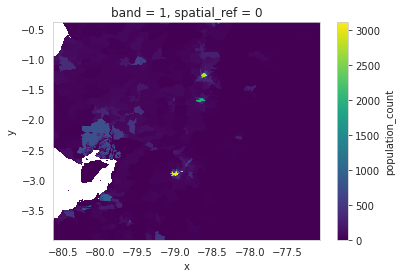

In [91]:
class2_census.plot()

In [92]:
class2['population'][0]

7869460.0

**Class 3** Up to 15 Million

In [93]:
class3_night = rioxarray.open_rasterio(f'../data/NightLightExport0905_0/{class3["file"][0]}')
class3_census = rioxarray.open_rasterio(f'../data/CensusExport0905_0/{class3["file"][0]}')

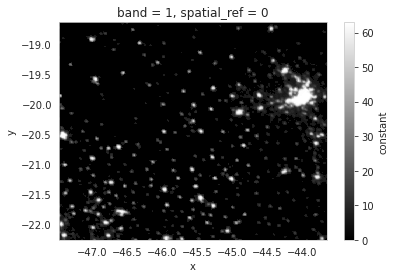

In [94]:
class3_night.plot(cmap = 'gray')

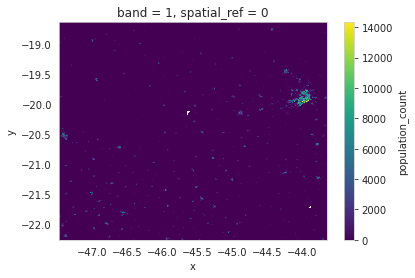

In [95]:
class3_census.plot()

In [96]:
class3["population"][0]

9871406.0

**Class 4** Up to 28 million

In [97]:
class4_night = rioxarray.open_rasterio(f'../data/NightLightExport0905_0/{class4["file"][0]}')
class4_census = rioxarray.open_rasterio(f'../data/CensusExport0905_0/{class4["file"][0]}')

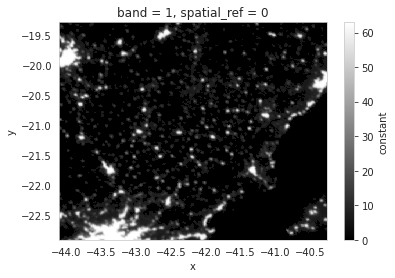

In [98]:
class4_night.plot(cmap = 'gray')

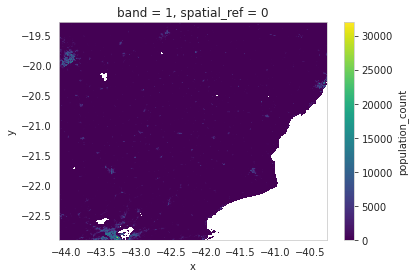

In [99]:
class4_census.plot()

In [100]:
class4["population"][0]

20430238.0

**Class 5** Up to 130 million

In [101]:
class5_night = rioxarray.open_rasterio(f'../data/NightLightExport0905_0/{class5["file"][0]}')
class5_census = rioxarray.open_rasterio(f'../data/CensusExport0905_0/{class5["file"][0]}')

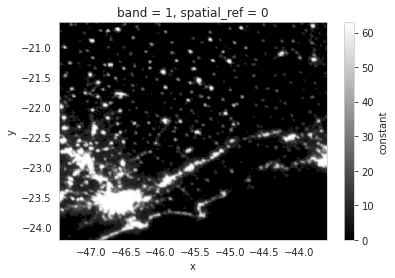

In [102]:
class5_night.plot(cmap = 'gray')

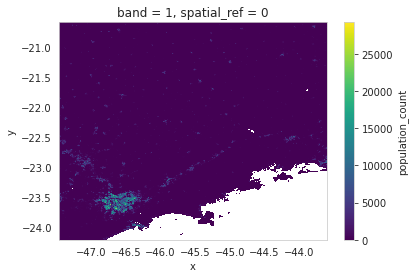

In [103]:
class5_census.plot()

In [104]:
class5["population"][0]

31819890.0

It looks like the difference between images at least shown above are pretty apparent. It gets a bit fuzzy when the population is near the population threshold between classes though.

## Separate out Train, Dev, Test

- I will keep 100 images to train from each bin
- Then about 10 images each for the dev and test

In [109]:
dev = class1.sample(10, random_state=42)
test = class1.drop(dev.index).sample(10, random_state=42)
train = class1.drop(dev.index).drop(test.index)

In [110]:
print(dev.shape)
print(test.shape)
print(train.shape)

(10, 3)
(10, 3)
(100, 3)


In [130]:
# Functionalize the above
def create_train_dev_test(df):

    dev = df.sample(10, random_state=42)
    test = df.drop(dev.index).sample(10, random_state=42)
    train = df.drop(dev.index).drop(test.index)

    dev = dev.reset_index(drop=True)
    test = test.reset_index(drop=True)
    train = train.reset_index(drop=True)

    return [dev, test, train]

In [131]:
data_split = create_train_dev_test(class1)

In [132]:
data_split[0].head()

,file,population
0,lat_-33.5831_lon_120.049_2000.tif,3.811604e+04
1,lat_-37.1667_lon_-62.7333_2000.tif,1.090975e+06
2,lat_-0.4833_lon_15.9_2005.tif,7.030537e+05
3,lat_18.2833_lon_121.4333_2000.tif,4.827988e+06
4,lat_-24.6667_lon_-65.05_2000.tif,1.572143e+06


In [133]:
data_split[1].head()

,file,population
0,lat_43.4833_lon_-6.1_2000.tif,4388013.50
1,lat_-2.4177_lon_115.2494_2000.tif,4622122.00
2,lat_-0.4833_lon_15.9_2010.tif,805109.25
3,lat_45.6883_lon_-122.5738_2000.tif,5223068.00
4,lat_32.0355_lon_-93.7004_2005.tif,3379022.50


In [134]:
data_split[2].head()

,file,population
0,lat_-0.3329_lon_10.3832_2000.tif,1211094.375
1,lat_-0.3329_lon_10.3832_2005.tif,1389460.625
2,lat_-0.3329_lon_10.3832_2010.tif,1597312.375
3,lat_-0.4833_lon_15.9_2000.tif,637792.500
4,lat_-10.1365_lon_19.2865_2000.tif,870824.375


In [136]:
print(data_split[0].shape)
print(data_split[1].shape)
print(data_split[2].shape)

(10, 2)
(10, 2)
(100, 2)


In [139]:
# create function to convert TIFF file to PIL and save in the right data directory
def organize_tiff_files(data_split : list, class_type : str, root_dir : str):

    dev = data_split[0]
    test = data_split[1]
    train = data_split[2]

    dev_init_path = f'../data/dev/{class_type}/'
    test_init_path = f'../data/test/{class_type}/'
    train_init_path = f'../data/training/{class_type}/'

    # dev
    for file in dev['file']:
        pil_image = convert_tiff_to_PIL(f'{root_dir}/{file}')
        file_name = file[0:-4]
        pil_image.save(f'{dev_init_path}{file_name}.jpg')

    # test
    for file in test['file']:
        pil_image = convert_tiff_to_PIL(f'{root_dir}/{file}')
        file_name = file[0:-4]
        pil_image.save(f'{test_init_path}{file_name}.jpg')

    # train
    for file in train['file']:
        pil_image = convert_tiff_to_PIL(f'{root_dir}/{file}')
        file_name = file[0:-4]
        pil_image.save(f'{train_init_path}{file_name}.jpg')


In [140]:
organize_tiff_files(data_split, 'class1', '../data/NightLightExport0905_0')

In [141]:
# repeat for other 4 classes
data_split = create_train_dev_test(class2)
organize_tiff_files(data_split, 'class2', '../data/NightLightExport0905_0')

data_split = create_train_dev_test(class3)
organize_tiff_files(data_split, 'class3', '../data/NightLightExport0905_0')

data_split = create_train_dev_test(class4)
organize_tiff_files(data_split, 'class4', '../data/NightLightExport0905_0')

data_split = create_train_dev_test(class5)
organize_tiff_files(data_split, 'class5', '../data/NightLightExport0905_0')